In [1]:
from random import choice
from nltk import CFG
from nltk import PCFG
import numpy as np
from timeit import default_timer as timer
from datetime import timedelta
import nltk

#### About
- Implementation for sampling from probabilistic context free grammars

#### Resources
- https://lost-contact.mit.edu/afs/cs.pitt.edu/projects/nltk/docs/tutorial/pcfg/nochunks.html
- https://docs.huihoo.com/nltk/0.9.5/en/ch07.html


#### Todo:
- Grammar for https://www.englishclub.com/grammar/rules.htm
- Add meta rules that allow to gernerically add rules

In [2]:
def sec_to_ms(s):
    m, s = divmod(s, 60)
    return '{:0>2} min {:.2f} sec'.format(m, s)

In [9]:
class Grammar():
    def __init__(self):
        self._G = None

    def from_string(self, string):
        self._G = PCFG.fromstring(string)
        self._parser = nltk.ViterbiParser(self._G)
        return self
    
    def sample(self, n=10):
        #return [' '.join(self._produce(self._G, self._G.start())) for _ in range(n)]
        return [self._produce(self._G, self._G.start()) for _ in range(n)]

    def _produce(self, grammar, symbol):
        words = []
        productions = grammar.productions(lhs = symbol)
        if len(productions) == 0:
            raise Exception("No rules to further expand available: lhs={}".format(symbol))
        all_probs = [p.prob() for p in productions]
        production = np.random.choice(productions, size=1, replace=True, p=all_probs)[0]
        for sym in production.rhs():
            if isinstance(sym, str):
                words.append(sym)
            else:
                words.extend(self._produce(grammar, sym))
        return words
    
    def is_valid(self, sentence):
        parsed = self._parser.parse(sentence)
        for subtree in parsed:
            if type(subtree) == nltk.tree.ProbabilisticTree and subtree.label() == 'S':
                return True
        return False
    
    def get_probs(self, sentence):
        parsed = self._parser.parse(sentence)
        probs = []
        for subtree in parsed:
            if type(subtree) == nltk.tree.ProbabilisticTree and subtree.label() == 'S':
                probs.append(subtree.prob())
        if len(probs) > 0:
            return probs
        raise Exception("Input is not a valid sentence!")
    
    def parse(self, sentence):
        return self._parser.parse(sentence)

### Simple Grammar

In [10]:
g = """
S -> A [1.0]
A -> 'a'B [0.5] | 'b'B [0.5]
B -> A [0.8] | 'c' [0.2]
"""
G = Grammar().from_string(g)
samples = G.sample(10)

for sample in samples:
    print("".join(sample))
    assert G.is_valid(sample)

aabbbc
aaaaabaabaac
bc
bc
bbbc
aabbaaac
aaabaabbabaababc
ac
babababbbaaaac
aac


In [11]:
g = """
S -> 'a' A [1.0]
A -> "a" A [0.5] | B [0.5]
B -> "b" [1.0]
"""

G = Grammar().from_string(g)
samples = G.sample(10)
print(samples)
print(G.is_valid(samples[0]))

[['a', 'b'], ['a', 'b'], ['a', 'b'], ['a', 'a', 'b'], ['a', 'b'], ['a', 'b'], ['a', 'a', 'a', 'b'], ['a', 'a', 'a', 'a', 'a', 'a', 'b'], ['a', 'b'], ['a', 'a', 'b']]
True


### Ambiguous Grammars

In [12]:
g = """
S -> A [0.5] | B [0.5]
A -> 'a' [1.0]
B -> 'a' [1.0]
"""
G = Grammar().from_string(g)
samples = G.sample(10)
print(samples)

[['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a']]


In [13]:
for sample in samples:
    print(G.is_valid(sample), G.get_probs(sample))

True [0.5]
True [0.5]
True [0.5]
True [0.5]
True [0.5]
True [0.5]
True [0.5]
True [0.5]
True [0.5]
True [0.5]


### Verbose Grammar

In [14]:
g = """
S -> SEN [1.0]
SEN -> SE1 [0.5] | SE1 CONJ SEN [0.5]
SE1 -> SUB PRE OBJ [1.0]
CONJ -> 'or' [0.1] | 'and' [0.9]
SUB -> 'A' [0.3] | 'B' [0.4] | "C" [0.3]
PRE -> 'likes' [0.8] | 'does' [0.2]
OBJ -> 'hiking' [0.2] | 'swimming' [0.8]
"""

G = Grammar().from_string(g)
samples = G.sample(5)
#
for sample in samples:
    print(" ".join(sample))

B likes swimming and C likes hiking
C likes swimming
B likes hiking
B likes swimming or C likes swimming and C likes swimming
C likes swimming and C likes swimming and B likes swimming


In [15]:
# validate samples
s1 = "A does swimming"
s2 = "A does B"
print(G.is_valid(s1.split()))
print(G.is_valid(s2.split()))

# prob of generating a sample
print(G.get_probs(s1.split()))

True
False
[0.024]


In [16]:
for subtree in G.parse(s1.split()):
    print(subtree)

(S (SEN (SE1 (SUB A) (PRE does) (OBJ swimming)))) (p=0.024)


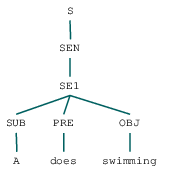

In [17]:
subtree

In [18]:
G._G.productions()

[S -> SEN [1.0],
 SEN -> SE1 [0.5],
 SEN -> SE1 CONJ SEN [0.5],
 SE1 -> SUB PRE OBJ [1.0],
 CONJ -> 'or' [0.1],
 CONJ -> 'and' [0.9],
 SUB -> 'A' [0.3],
 SUB -> 'B' [0.4],
 SUB -> 'C' [0.3],
 PRE -> 'likes' [0.8],
 PRE -> 'does' [0.2],
 OBJ -> 'hiking' [0.2],
 OBJ -> 'swimming' [0.8]]

### Another Toy

In [ ]:
g

In [ ]:
g = """
  S -> NP VP [1.0]
  VP -> V NP [0.5] | V NP PP [0.5]
  V -> "saw" [0.5] | "ate" [0.5]
  NP -> "John" [0.1] | "Mary" [0.1] | "Bob" [0.1] | Det N [0.3] | Det N PP [0.4]
  Det -> "a" [0.25] | "an" [0.25] | "the" [0.25] | "my" [0.25]
  N -> "dog" [0.25] | "cat" [0.25] | "cookie" [0.25] | "park" [0.25]
  PP -> P NP [1.0]
  P -> "in" [0.25] | "on" [0.25] | "by" [0.25] | "with" [0.25]
"""
G = Grammar().from_string(g)

In [ ]:
samples = G.sample(10)

In [ ]:
for sample in samples:
    print(" ".join(sample))

### Simple ENglish

In [ ]:
g = """
S -> NP_Sg VP_Sg | NP_Pl VP_Pl
NP -> NP_Pl      | NP_Sg
NP_Sg ->       N_Sg | Det_Sg N_Sg | Det_Both N_Sg | Adj N_Sg | Det_Sg Adj N_Sg | Det_Both Adj N_Sg| PropN_Sg
NP_Pl ->       N_Pl | Det_Pl N_Pl | Det_Both N_Pl | Adj N_Pl | Det_Pl Adj N_Pl | Det_Both Adj N_Pl| PropN_Pl
VP_Sg -> IV_Pres_Sg | IV_Past     | TV_Pres_Sg    | TV_Past  | TV_Pres_Sg NP   | TV_Past NP       | Adv IV_Pres_Sg | Adv IV_Past | Adv TV_Pres_Sg NP | Adv TV_Past NP
VP_Pl -> IV_Pres_Pl | IV_Past     | TV_Pres_Pl    | TV_Past  | TV_Pres_Pl NP   | TV_Past NP       | Adv IV_Pres_Pl | Adv IV_Past | Adv TV_Pres_Pl NP | Adv TV_Past NP
N_Pl -> 'girls' | 'boys' | 'children' | 'cars' | 'apples' | 'dogs'
Adj -> 'good' | 'bad' | 'beautiful' | 'innocent'
Adv -> 'happily' | 'sadly' | 'nicely'
N_Sg -> 'dog' | 'girl' | 'car' | 'child' | 'apple' | 'elephant'
PropN_Sg -> 'rashmi' | 'piyumika'
PropN_Pl -> 'they'  | 'i'
Det_Sg -> 'this' | 'every' | 'a' | 'an'
Det_Pl -> 'these' | 'all'
Det_Both -> 'some' | 'the' | ' several'
IV_Pres_Sg -> 'dissappeares' | 'walks'
TV_Pres_Sg -> 'sees' | 'likes' |'eat'
IV_Pres_Pl -> 'dissappear' | 'walk'
TV_Pres_Pl ->'see' | 'like'
IV_Past -> 'dissappeared' | 'walked'
TV_Past -> 'saw' | 'liked' | 'ate' | 'shot'
"""
G = CFG.fromstring(g)

In [ ]:
def produce(grammar, symbol):
    words = []
    productions = grammar.productions(lhs = symbol)
    if len(productions) == 0:
        raise Exception("No rules to further expand available: lhs={}".format(symbol))
        
    production = choice(productions)
    for sym in production.rhs():
        if isinstance(sym, str):
            words.append(sym)
        else:
            words.extend(produce(grammar, sym))
    return words

In [ ]:
for _ in range(100):
    s = produce(G, G.start())
    print(" ".join(s))

# Feature Grammars
- http://www.nltk.org/book_1ed/ch09.html
- https://stackoverflow.com/questions/55770861/loading-and-editing-a-cfg-file-for-grammar-parsing
- http://www.nltk.org/howto/featgram.html

# Test Language

#### Ideas
Syntax = Semantic, there are no ambiguous expressions

#### Rules
- There can be an infinite amount of brackets
- The each opening bracket needs a closing bracket
- within a bracket, there can be a sentence constructed from the following rules:
    - |b| = |a|
    - if there is a c in the beginning, than there is a d in the end
    - if there are two cs in the beginning, than there is an e in the end
    - for a g in the beginning, there is a f in the end
    - for a f in the beginning, there is a g in the end

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from tqdm import tqdm

In [82]:
p_grammar = Path("data") / "grammar-00.pkl"
sample_max_len = 32
sample_min_len = 2

In [83]:
g = """
S -> S S [0.2] | '(' SEN ')' [0.2] | '[' SEN ']' [0.2] | '(' S ')' [0.2] | '[' S ']' [0.2]
SEN -> SI [0.4] | SD [0.3] | SE [0.3]
SD -> 'c' SI 'd' [1.0]
SE -> 'c' 'c' SI 'e' [1.0]
SI -> 'a' B [0.25] | B 'a' [0.25] | 'b' A [0.25] | A 'b' [0.25]
B -> SI 'b' [0.3] | 'b' SI [0.3] | 'b' [0.4]
A -> 'a' SI [0.3] | SI 'a' [0.3] | 'a' [0.4]
"""
G = Grammar().from_string(g)

In [94]:
samples = G.sample(1000000)

In [95]:
voc = set([])

all_samples = []
for sample in tqdm(samples):
    voc = voc | set(sample)
    if len(sample) > sample_min_len and len(sample) < sample_max_len:
        all_samples.append("".join(sample))
all_samples = list(set(all_samples))

100%|██████████| 1000000/1000000 [00:01<00:00, 956563.01it/s]


In [105]:
print(len(all_samples))
print(voc)

203403
{'[', 'd', 'c', ')', 'b', 'e', '(', 'a', ']'}


In [107]:
train_ratio = 0.8
n_train = int(len(all_samples) * train_ratio)
samples_train = all_samples[:n_train]
samples_valid = all_samples[n_train:]
print(len(samples_train))
print(len(samples_valid))

162722
40681


In [120]:
corpus = {
    "grammar": g,
    "vocabulary": voc,
    "data_train": samples_train,
    "data_valid": samples_valid,
    "n_samples": len(all_samples),
    "token_len_min": np.min([len(s) for s in all_samples]),
    "token_len_max": np.max([len(s) for s in all_samples])
}

In [121]:
with open(p_grammar, "wb") as file:
    pickle.dump(corpus, file)

In [111]:
voc

{'(', ')', '[', ']', 'a', 'b', 'c', 'd', 'e'}

In [112]:
len(all_samples)

203403

In [113]:
for sample in all_samples[:100]:
    print(sample)

(ccbabbaae)[cabaabaaababbbbd]
[(([babbabaa]))(ccaabababbe)]
(((([ba][[[(ccabababe)]]]))))
(babbaabbabaabbaa)
(baab)(ccbabaabe)
([[(ccbbaabbabaabae)]])
([abaabb][cabbabbaad])
[ccabe][(cbabaabbad)]
[[[bbbabaaababbbaabaa]]]
(baabaabaabbbba)
(((cababd)))((ccbbaabae))(abba)
(cbaabd)[(cababababd)]
[([cbaabbaababd])][cababd]
((bbabbabababaabaaabba))
(([[cbaabd]([[ccbabababae]])]))
(([[ccabbabae](ccbae)]))
[((baab)[([((ccbae))])])]
((([baabbaba])(ccabe)))
[(ccabe)][ccabe]
[ccbbaaababababbabbaae]
(ab)([cababd])[cbaabbad]
(ba)((ba))[ba]
[caabbd](ccbaabe)
((([[(ab)]])[((ccbae))][ab]))
[ccbbabababaae](baba)
[cbbaad][[ccabe]]
([abababbabaabab])
(ccaabbe)(ccaabbe)
[[[(abbaba)]]](cbabaabababd)
[aababbab][cbaabd]
((([[bbaa]])))
[[((([((ccbae))])[abab]))]]
[([(ccbabababaabbabae)])]
[ccababababe][(baab)]
([(cbabad)](ccbaabe))
(cbbaabad)[ccabbae]
(abba)(baab)
[[(cabd)]][abab]
([((cbbaad))[([cbad])]])
[[aaabababbb]]
(baab)[[cbaabbabaabaabbd]]
[[ccbabaabbabae]][[ccbbaae]]
(([([cabd])(cbaabd)]))
[caaabababb